In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import math
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence, pack_sequence
import torch.nn.utils.rnn as rnn_utils
from torchvision import datasets, transforms

#Problem 1:

In [41]:
# Setting device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Loading MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

Using device: cpu


100%|██████████| 9912422/9912422 [00:00<00:00, 12681847.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46447735.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12922189.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9265821.39it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# NN class definition
class DynamicMNISTModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_flag=0):
        super(DynamicMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        layers = []

        # Choosing the activation function based on activation_flag
        if activation_flag == 1:
            activation = nn.Sigmoid()
        elif activation_flag == 2:
            activation = nn.Tanh()
        elif activation_flag == 3:
            activation = nn.ELU()
        else:
            # Default is ReLU
            activation = nn.ReLU()

        if len(hidden_sizes) == 0:
            # No hidden layers, only input and output layers
            layers.append(nn.Linear(input_size, output_size))
        else:
            # First layer
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.LayerNorm(hidden_sizes[0]))
            layers.append(activation)
            # Hidden layers
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                layers.append(nn.LayerNorm(hidden_sizes[i]))
                layers.append(activation)
            # Output layer
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

In [ ]:
# SGD Optimizer
def SGD_optim(model):
    return optim.SGD(model.parameters(), lr=0.0015, momentum=0.9)

In [ ]:
# Adam Optimizer
def Adam_optim(model):
    return optim.Adam(model.parameters(), lr=0.0015)

In [ ]:
# Training & Testing Model
def train_and_test_model(model, train_loader, test_loader, epochs=10, flag=1):
    optimizer = SGD_optim(model) if flag == 1 else Adam_optim(model)
    loss_function = nn.CrossEntropyLoss()
    model.to(device)

    total_training_time = 0

    for epoch in range(epochs):
        total_train_loss, total_train_samples = 0, 0
        total_test_loss, total_test_samples = 0, 0

        start_time = time.time()

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            train_loss = loss_function(outputs, labels)
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item() * labels.size(0)
            total_train_samples += labels.size(0)

        total_training_time += time.time() - start_time

        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                test_loss = loss_function(outputs, labels)

                total_test_loss += test_loss.item() * labels.size(0)
                total_test_samples += labels.size(0)

    average_train_loss_last_epoch = total_train_loss / total_train_samples
    average_test_loss_last_epoch = total_test_loss / total_test_samples
    print(f"train loss={average_train_loss_last_epoch}, test loss={average_test_loss_last_epoch}")

    return average_train_loss_last_epoch, average_test_loss_last_epoch, total_training_time

In [ ]:
def Problem4(hidden_sizes):
    model = DynamicMNISTModel(28*28, hidden_sizes, 10).to(device)
    avg_train_loss1, avg_test_loss1, train_time1 = train_and_test_model(model, train_loader, test_loader)
    return model

In [ ]:
# Train & Test for Decreasing size - best model from P4
hidden_sizes = [575, 475, 375, 250]
modelP4 = Problem4(hidden_sizes)

train loss=0.016592147344350813, test loss=0.06437768416907638


In [ ]:
# Train & Test for base softmax model
hidden_sizes = []
modelbase = Problem4(hidden_sizes)

train loss=0.2889441215912501, test loss=0.28367612758874894


In [ ]:
modelP4.eval()
modelbase.eval()

DynamicMNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
# Generating initial random images for optimization.
initial_images = torch.rand(10, 1, 28, 28, requires_grad=True)

# Regularization strength parameter to control the L2 regularization term.
lambda_reg = 0.1

# Function to optimize an image to maximize the probability of a target digit classification.
def optimize_image(model, target_digit, initial_image, iterations=1000, learning_rate=0.01):
    image = initial_image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([image], lr=learning_rate)

    for i in range(iterations):
        optimizer.zero_grad()
        output = model(image)
        # Computing the log probabilities using a softmax function.
        log_probs = F.log_softmax(output, dim=1)
        # Calculate the loss as the negative log probability of the target digit.
        loss = -log_probs[0, target_digit]

        # Add the L2 regularization term to the loss.
        l2_reg = lambda_reg * torch.sum(image ** 2)
        total_loss = loss + l2_reg

        total_loss.backward()
        optimizer.step()

        # Clamp the image data to be within the valid range of [0, 1] after each update.
        image.data = image.data.clamp_(0, 1)
    return image.detach()

In [ ]:
# Generate optimized images for each digit using the base model.
optimized_images_simple = [optimize_image(modelbase, digit, initial_images[digit].unsqueeze(0)) for digit in range(10)]

# Generate optimized images for each digit using the more complex model from P4.
optimized_images_complex = [optimize_image(modelP4, digit, initial_images[digit].unsqueeze(0)) for digit in range(10)]

Base Model: 0 to 9 images


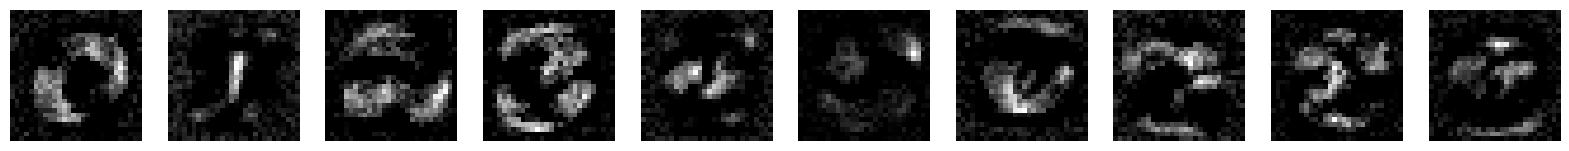

P4 Model: 0 to 9 images


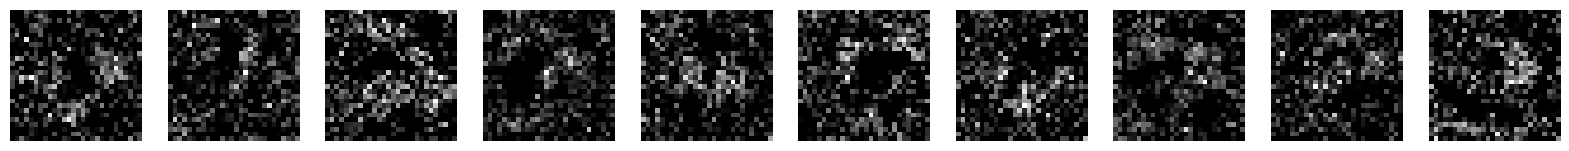

In [ ]:
def show_images(images):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

# Converting the list of tensors to a tensor for easy manipulation
optimized_images_simple_tensor = torch.cat([img for img in optimized_images_simple], dim=0)
optimized_images_complex_tensor = torch.cat([img for img in optimized_images_complex], dim=0)

print("Base Model: 0 to 9 images")
show_images(optimized_images_simple_tensor)
print("P4 Model: 0 to 9 images")
show_images(optimized_images_complex_tensor)

Base Model: 0 to 9 images


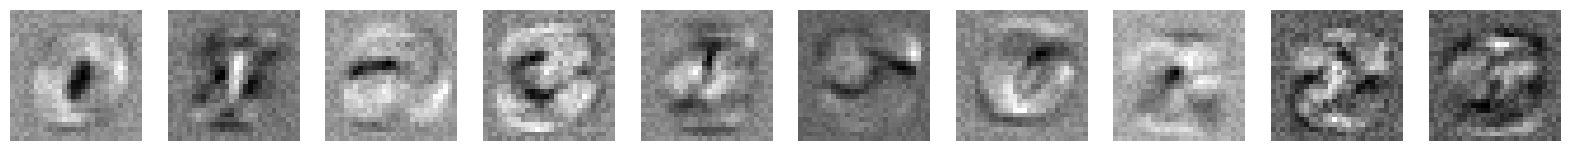

P4 Model: 0 to 9 images


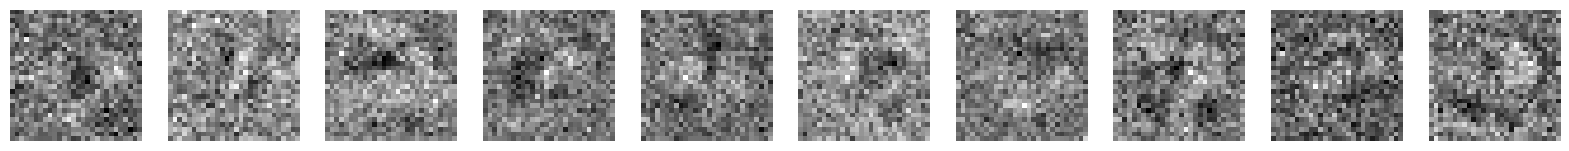

In [ ]:
# clamped -0.5 to 0.5 (not required - but just attached for additional observation)
# re-ran the above code with one modification - in the optimize_image function change "image.data = image.data.clamp_(0, 1) to the following:
# image.data = image.data.clamp_(-0.5, 0.5)

**Notes on Problem 1:**
- The images were optimized using Adam optimizer with a learning rate of 0.01

**Q. How can you formulate this as a minimization problem? What would the variables be, and what would the loss function be? Note: Regularization may be useful here.**

Ans:
- **Minimization:** By minimizing the loss function we calculate how unlikely it is for a modified input image to be classified as the target digit by the NN model. This is achieved by optimizing the pixel values of an initial image so that the model's predicted probability for the target digit is maximized, which is equivalent to minimizing the negative log probability for that digit.
- **Variables:** The variables in this optimization problem are the pixel values of the image being optimized. These pixels are represented as tensor and are initialized at random.
- **Loss Function:** The primary component is the negative log probability of the traget digit's class in the model's output distribution. This can be achieved by applying the softmax function to the logits output by the model and then taking the logarithm. The second component is the **L2 regularization** term, which penalizes large pixel values to avoid overfitting to the model's predictions and to keep the optimized image within a realistic range.
- Additionally, the vector image was **clamped** to constrian the values within a valid range. The output above is for two different ranges: (0, 1) and (-0.5, 0.5).

**Q. Formulate how to solve the problem for the optimal digit images**

Ans: To solve for the optimal digit images, we formula as a optimization problem where the goal is to modify pixels of an initially randomly generated image such that a trained NN model assigns the highest possible probability to the corresponding target digit class. The detailed formualtion is described in the steps above (Minimization, Variables, Loss Function, Clamping).
Additional details: We will run the optimization loop for some fixed iterations. We will use Adam optimizer to optimize the images. We will use back propogation to compute gradients of the loss function with respect to the image pixels.

**Q. Find and display the ten optimal images for the no hidden layer network.**

Ans: Displayed above (This is labeled as "Base Model: 0 to 9 images" in the output. The images are displayed horizontally in the order 0 to 9)

**Q. Find and display the ten optimal images for the optimal network**

Ans: Displayed above (This is labeled as "P4 Model: 0 to 9 images" in the output. The images are displayed horizontally in the order 0 to 9)
The optimal network here is the best network that was observed from HW 2 Problem 4.

**Q. What do the images suggest about what the two networks are looking for, in terms of features? Any similarities or differences?**

Ans:

Base Model: The base model has no hidden layers and so it can't learn any complex features or patterns. It can only learn the most simplest form of the images. The most simplest feature or form of the image is the correct image itself. It learns to recognize digits by identifying and using simple patterns that correspond to the actual data. So, when optimizing using base model, we see the images generated correspond to the actual digits.

P4 Model: In contrast, the images optimized for the P4 model, which is a more complex model with multiple hidden layers can learn more complex features and patterns. So, the generated images doesn't necessarily have to correspond to the actual clear digits. From the generated images we can conclude that they learn features such as edges, corners, or complex pattern of actual digit images. This are not visible clearly as digits to human eye (From the output we can confirm that they somewhat correspond to actual digit images but it's hard to trace and identify). The P4 model is better than Base model because of these complex features that the P4 model has learned. As a result, P4 model can predict better in case the images are presented in various forms.

Similarity: In essence, both models are looking for patterns/features that increase the probability of the desired classification.

Difference: The key difference is the level of complexity of the features each model is focusing on.

In summary, the base model relies on simpler, more obvious features that closely resemble the digits, while the P4 model relies on complex patterns that may capture more abstract representations of the digits.

**Bonus:**

**How should you decide when to stop training? What does overfitting/over training mean here?**

Ans: Early Stopping can be used to prevent overfitting. We can monitor loss on the testing data or validation data and if the model's performance starts to worsen, we stop the the training process at this point.

We can use the "best_loss" parameter which keeps track of the lowest loss so far. We can have a "patience" parameter that keeps track of the count/resistance/patience for which we want to allow the model to run. For example, is patience is set to 3. We will wait for 3 consecutive runs. If all 3 runs had loss increasing compared to best_loss observed we terminate the training loop.

Overfitting/Overtraining here would occur as a result of access optimization or training. As a result, the optimized images become over specialized to the model used for optimization. They start to learn the features of the digit so well that they loose their complexity and loose ability to generalize well on the unseen data.

#Problem 2:

In [2]:
def generate_data(num_sequences=5000, max_sequence_length=100, min_sequence_length=1, change_point_limit=100):
    sequences = []
    labels = []

    for _ in range(num_sequences):
        sequence_length = np.random.randint(min_sequence_length, max_sequence_length + 1)
        change_point = np.random.randint(0, change_point_limit)

        sequence = np.random.normal(0, 1, (sequence_length, 10))

        label = np.zeros(sequence_length)

        if change_point < sequence_length:
            change_indices = np.random.choice(10, 5, replace=False)
            change_values = np.random.uniform(-1, 1, size=5)

            for t in range(change_point, sequence_length):
                sequence[t, change_indices] += change_values
                label[t] = 1

        sequences.append(sequence)
        labels.append(label)

    return sequences, labels

sequences, labels = generate_data()

**Part 1: Change Point Detection using RNN's**

In [3]:
class VariableLengthSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(sequence, dtype=torch.float32) for sequence in sequences]
        self.labels = [torch.tensor(label, dtype=torch.float32) for label in labels]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels_padded = pad_sequence(labels, batch_first=True)
    return sequences_padded, labels_padded, torch.tensor(lengths)

In [4]:
full_dataset = VariableLengthSequenceDataset(sequences, labels)

num_train = int(0.8 * len(full_dataset))
num_test = len(full_dataset) - num_train
train_dataset, test_dataset = random_split(full_dataset, [num_train, num_test])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)
        self.layer_norm = nn.LayerNorm(20)
        self.fc = nn.Linear(20, 1)

    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        output = self.layer_norm(output)
        output = self.fc(output)
        return torch.sigmoid(output)

lstmModel = LSTMModel()
total_params = sum(p.numel() for p in lstmModel.parameters())
print(f'Total number of parameters in LSTMModel: {total_params}')

Total number of parameters in LSTMModel: 5981


In [6]:
# training and testing lstmModel
criterion = nn.BCELoss()
optimizer = optim.Adam(lstmModel.parameters(), lr = 0.001)

for epoch in range(15):
    # Training phase
    lstmModel.train()
    total_loss = 0
    for seqs, lbls, _ in train_dataloader:
        lengths = [len(seq) for seq in seqs]

        optimizer.zero_grad()
        outputs = lstmModel(seqs, lengths)
        loss = criterion(outputs.squeeze(), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_dataloader)

    # Evaluation phase
    lstmModel.eval()
    total_loss = 0
    with torch.no_grad():
        for seqs, lbls, _ in test_dataloader:
            lengths = [len(seq) for seq in seqs]

            outputs = lstmModel(seqs, lengths)
            loss = criterion(outputs.squeeze(), lbls)
            total_loss += loss.item()
    avg_test_loss = total_loss / len(test_dataloader)

    print(f'Epoch {epoch+1}, Train loss = {avg_train_loss:.4f}, Test loss = {avg_test_loss:.4f}')

Epoch 1, Train loss = 0.4169, Test loss = 0.3341
Epoch 2, Train loss = 0.2979, Test loss = 0.2589
Epoch 3, Train loss = 0.2420, Test loss = 0.2383
Epoch 4, Train loss = 0.2212, Test loss = 0.2125
Epoch 5, Train loss = 0.2084, Test loss = 0.2055
Epoch 6, Train loss = 0.2025, Test loss = 0.2044
Epoch 7, Train loss = 0.1991, Test loss = 0.1967
Epoch 8, Train loss = 0.1957, Test loss = 0.1953
Epoch 9, Train loss = 0.1900, Test loss = 0.1950
Epoch 10, Train loss = 0.1878, Test loss = 0.1912
Epoch 11, Train loss = 0.1865, Test loss = 0.1921
Epoch 12, Train loss = 0.1835, Test loss = 0.1903
Epoch 13, Train loss = 0.1836, Test loss = 0.1889
Epoch 14, Train loss = 0.1832, Test loss = 0.1912
Epoch 15, Train loss = 0.1833, Test loss = 0.1982


In [70]:
def evaluate_and_plot(model, test_dataloader):
    distances = list(range(-10, 11))
    detection_probabilities = {distance: [] for distance in distances}

    model.eval()
    with torch.no_grad():
        for sequences, labels, _ in test_dataloader:
            lengths = [len(seq) for seq in sequences]

            sequences_tensor = torch.stack(sequences) if not isinstance(sequences[0], torch.Tensor) else sequences
            labels_tensor = torch.stack(labels) if not isinstance(labels[0], torch.Tensor) else labels

            outputs = model(sequences_tensor, lengths).squeeze()

            for i, length in enumerate(lengths):
                label = labels_tensor[i][:length]
                nonzero_elements = label.nonzero(as_tuple=False).squeeze()
                if nonzero_elements.numel() > 0:
                    change_point = nonzero_elements.min().item()

                    for distance in distances:
                        timestep = change_point + distance
                        if 0 <= timestep < length:
                            detection_probabilities[distance].append(outputs[i, timestep].item())

    avg_detection_probabilities = {distance: np.mean(probabilities) if probabilities else 0
                                   for distance, probabilities in detection_probabilities.items()}

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(distances, list(avg_detection_probabilities.values()), marker='.', linestyle='-')
    plt.xlabel("Distance from Change Point")
    plt.ylabel("Detection Probability")
    plt.title("Detection Probability vs. Distance from Change Point")
    plt.grid(True)
    plt.show()

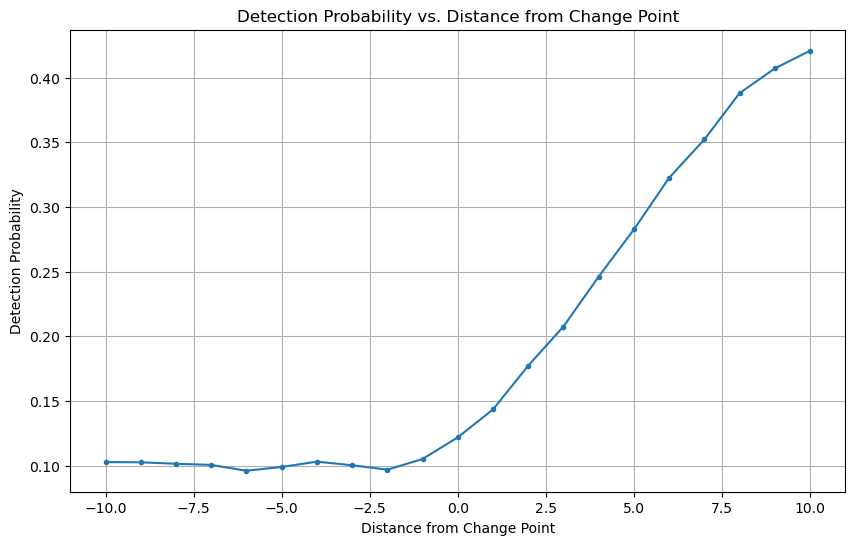

In [71]:
evaluate_and_plot(lstmModel, test_dataloader)

**Part 2: Change Point Detection using CNN's**

In [78]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(10, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x.squeeze(-1)

cnnModel = CNNModel()
total_params = sum(p.numel() for p in cnnModel.parameters())
print(f'Total number of parameters in CNNModel: {total_params}')

Total number of parameters in CNNModel: 7457


In [79]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for sequences, labels, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        # Testing loop
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for sequences, labels, _ in test_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

criterion = nn.BCELoss()
optimizer = optim.Adam(cnnModel.parameters(), lr=0.001)

train_and_evaluate(cnnModel, train_dataloader, test_dataloader, criterion, optimizer, epochs=15)

Epoch 1/15, Train Loss: 0.5264, Test Loss: 0.4200
Epoch 2/15, Train Loss: 0.3752, Test Loss: 0.3475
Epoch 3/15, Train Loss: 0.3316, Test Loss: 0.3205
Epoch 4/15, Train Loss: 0.3114, Test Loss: 0.3050
Epoch 5/15, Train Loss: 0.2964, Test Loss: 0.2932
Epoch 6/15, Train Loss: 0.2874, Test Loss: 0.2868
Epoch 7/15, Train Loss: 0.2802, Test Loss: 0.2844
Epoch 8/15, Train Loss: 0.2762, Test Loss: 0.2762
Epoch 9/15, Train Loss: 0.2716, Test Loss: 0.2798
Epoch 10/15, Train Loss: 0.2708, Test Loss: 0.2732
Epoch 11/15, Train Loss: 0.2682, Test Loss: 0.2735
Epoch 12/15, Train Loss: 0.2658, Test Loss: 0.2716
Epoch 13/15, Train Loss: 0.2681, Test Loss: 0.2699
Epoch 14/15, Train Loss: 0.2649, Test Loss: 0.2763
Epoch 15/15, Train Loss: 0.2635, Test Loss: 0.2668


In [80]:
def evaluate_and_plot(model, test_loader):
    model.eval()
    distances = list(range(-10, 11))
    detection_probabilities = {distance: [] for distance in distances}

    with torch.no_grad():
        for sequences, labels, lengths in test_loader:
            outputs = model(sequences)

            for batch_index, seq_length in enumerate(lengths):
                label = labels[batch_index][:seq_length]
                output = outputs[batch_index][:seq_length]

                change_points = (label == 1).nonzero(as_tuple=False)

                if change_points.nelement() == 0:
                    continue

                change_point = change_points[0, 0].item()

                for distance in distances:
                    timestep = change_point + distance
                    if 0 <= timestep < seq_length:
                        detection_probability = output[timestep].item()
                        detection_probabilities[distance].append(detection_probability)

    avg_detection_probs = [np.mean(detection_probabilities[dist]) if detection_probabilities[dist] else 0 for dist in distances]

    plt.figure(figsize=(10, 6))
    plt.plot(distances, avg_detection_probs, marker='.', linestyle='-')
    plt.xlabel('Distance from Change Point')
    plt.ylabel('Average Detection Probability')
    plt.title('Detection Probability vs. Distance from Change Point')
    plt.grid(True)
    plt.show()

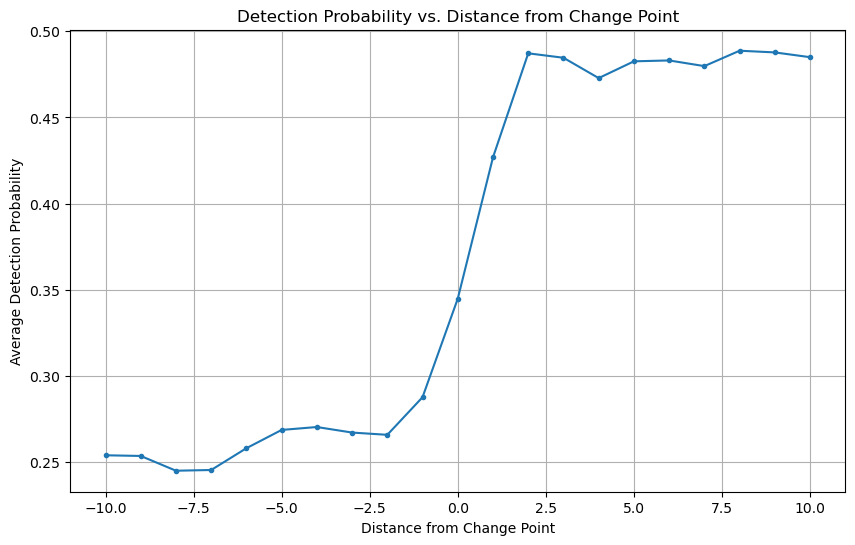

In [81]:
evaluate_and_plot(cnnModel, test_dataloader)

#Problem 3:

**Que: Show that you can write code for summary and query that doesn’t rely on neural networks at all, and is perfectly accurate**

In [22]:
def summarize(seq):
  summary = [0]*10
  for num in seq:
    summary[num] += 1
  return summary

def query(summary, q):
  return summary[q] > 0

seq = [1, 2, 3, 4, 5, 1, 2, 3, 4, 5]
summary = summarize(seq)
print("Summary:", summary)
print("Query for 3:", query(summary, 3))
print("Query for 8:", query(summary, 8))

Summary: [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Query for 3: True
Query for 8: False


**Part 1: A query is of length 1 which contains an embedded integer**

**One thing to think about - what do you want the dimension of the summary vector to be?**
The dimension of the query vector can be 64

**Formulate the problem and generate data**
**Train the embedding and two networks, and evaluate the results**
Note: The embedding is trainable in the following code

In [61]:
def generate_data(datapoints=1000, sequence_length=10):
    sequences = torch.zeros((datapoints, sequence_length), dtype=torch.long)
    queries = torch.zeros((datapoints, 1), dtype=torch.long)
    labels = torch.zeros((datapoints, 1), dtype=torch.float)

    for i in range(datapoints):
        seq = torch.randint(0, 10, (sequence_length,))
        qry = torch.randint(0, 10, (1,))

        sequences[i] = seq
        queries[i] = qry
        labels[i] = 1 if qry.item() in seq.tolist() else 0

    return sequences, queries, labels.squeeze()

In [62]:
train_sequences, train_queries, train_labels = generate_data(32000)
test_sequences, test_queries, test_labels = generate_data(8000)

class SequenceDataset(Dataset):
    def __init__(self, sequences, queries, labels):
        self.sequences = sequences
        self.queries = queries
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.queries[idx], self.labels[idx]

train_dataset = SequenceDataset(train_sequences, train_queries, train_labels)
test_dataset = SequenceDataset(test_sequences, test_queries, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

embedding = nn.Embedding(10, embedding_dim=2)

In [33]:
class Summary(nn.Module):
    def __init__(self, embedding_dim=2):
        super(Summary, self).__init__()
        self.gru1 = nn.GRU(embedding_dim, 8, batch_first=True)
        self.gru2 = nn.GRU(8, 16, batch_first=True)
        self.gru3 = nn.GRU(16, 32, batch_first=True)
        self.fc = nn.Linear(32, 64)

    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        x = x[:, -1, :]  # Take last output for summary
        x = torch.relu(self.fc(x))
        return x

summary = Summary()
print(summary)
total_params = sum(p.numel() for p in summary.parameters())
print(f'Total number of parameters in Summary: {total_params}')

Summary(
  (gru1): GRU(2, 8, batch_first=True)
  (gru2): GRU(8, 16, batch_first=True)
  (gru3): GRU(16, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Total number of parameters in Summary: 8448


In [34]:
class Query(nn.Module):
    def __init__(self, summary_dim=64, embedding_dim=2):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(summary_dim + embedding_dim, 100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, summary, q):
        x = torch.cat((summary, q), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
query = Query()
print(query)
total_params = sum(p.numel() for p in query.parameters())
print(f'Total number of parameters in Query: {total_params}')

Query(
  (fc1): Linear(in_features=66, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Total number of parameters in Query: 6801


In [63]:
def train_test_P3(epochs=70):
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(list(embedding.parameters()) + list(summary.parameters()) + list(query.parameters()), lr = 0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training loop
    for epoch in range(epochs):
        total_train_loss = 0
        summary.train()
        query.train()

        for seq, qry, lbl in train_loader:
            seq, qry, lbl = seq.to(device), qry.to(device), lbl.to(device)
            optimizer.zero_grad()
            
            embedded_seq = embedding(seq)
            summary_vector = summary(embedded_seq)
            
            embedded_qry = embedding(qry).squeeze(1)
            prediction = query(summary_vector, embedded_qry)
            
            # Correct the loss computation
            train_loss = loss_function(prediction, lbl.view(-1, 1))
            train_loss.backward()
            optimizer.step()
            
            total_train_loss += train_loss.item()
        
        # Average training loss
        avg_train_loss = total_train_loss / len(train_loader)

        # Testing loop
        total_test_loss = 0
        summary.eval()
        query.eval()

        with torch.no_grad():
            for seq, qry, lbl in test_loader:
                seq, qry, lbl = seq.to(device), qry.to(device), lbl.to(device)
                
                embedded_seq = embedding(seq)
                summary_vector = summary(embedded_seq)
                
                embedded_qry = embedding(qry).squeeze(1)
                prediction = query(summary_vector, embedded_qry)
                
                # Correct the loss computation
                test_loss = loss_function(prediction, lbl.view(-1, 1))
                total_test_loss += test_loss.item()
        
        # Average testing loss
        avg_test_loss = total_test_loss / len(test_loader)
        
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

In [36]:
train_test_P3()

Epoch 1, Train Loss: 0.6311, Test Loss: 0.6131
Epoch 2, Train Loss: 0.6117, Test Loss: 0.6087
Epoch 3, Train Loss: 0.5923, Test Loss: 0.5721
Epoch 4, Train Loss: 0.5475, Test Loss: 0.5416
Epoch 5, Train Loss: 0.5352, Test Loss: 0.5335
Epoch 6, Train Loss: 0.5317, Test Loss: 0.5359
Epoch 7, Train Loss: 0.5289, Test Loss: 0.5283
Epoch 8, Train Loss: 0.5265, Test Loss: 0.5285
Epoch 9, Train Loss: 0.5249, Test Loss: 0.5284
Epoch 10, Train Loss: 0.5217, Test Loss: 0.5241
Epoch 11, Train Loss: 0.5138, Test Loss: 0.5123
Epoch 12, Train Loss: 0.4847, Test Loss: 0.4708
Epoch 13, Train Loss: 0.4585, Test Loss: 0.4543
Epoch 14, Train Loss: 0.4460, Test Loss: 0.4466
Epoch 15, Train Loss: 0.4358, Test Loss: 0.4388
Epoch 16, Train Loss: 0.4258, Test Loss: 0.4291
Epoch 17, Train Loss: 0.4161, Test Loss: 0.4116
Epoch 18, Train Loss: 0.3993, Test Loss: 0.3956
Epoch 19, Train Loss: 0.3847, Test Loss: 0.3828
Epoch 20, Train Loss: 0.3732, Test Loss: 0.3803
Epoch 21, Train Loss: 0.3589, Test Loss: 0.3588
E

In [37]:
def plot_embeddings(embedding_layer):
    embeddings = embedding_layer.weight.data.cpu().numpy()
    
    # Plotting
    plt.figure(figsize=(8, 6))
    for i, embed in enumerate(embeddings):
        plt.scatter(embed[0], embed[1], label=str(i))
        plt.text(embed[0], embed[1], f'{i}', fontsize=9, ha='right')
    
    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.title('2D Embedding Space for Integers 0-9')
    plt.legend()
    plt.grid(True)
    plt.show()

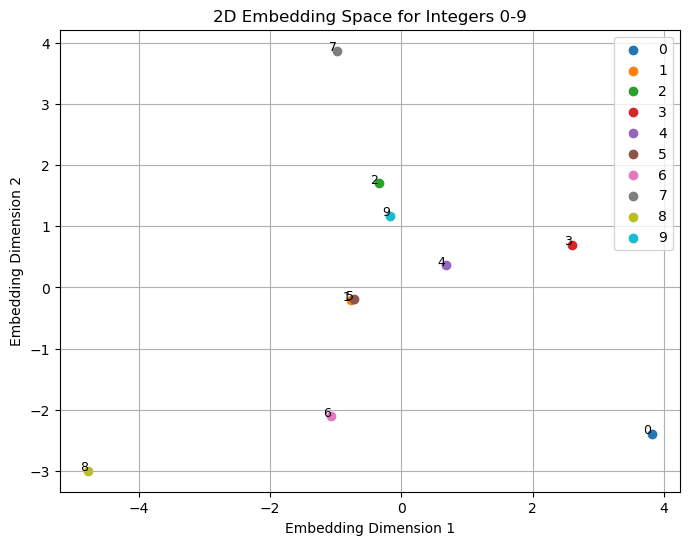

In [38]:
plot_embeddings(embedding)

**Bonus:**

**Show that you can get good results using just a fixed random embedding, but that you can get better results with a trained embedding.**

Note: The code above is for embedding that is trainable. The following code is for embedding that is not trainable or is fixed. The embedding, summary, and query are trained simultaneously.

In [56]:
train_sequences, train_queries, train_labels = generate_data(32000)
test_sequences, test_queries, test_labels = generate_data(8000)

class SequenceDataset(Dataset):
    def __init__(self, sequences, queries, labels):
        self.sequences = sequences
        self.queries = queries
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.queries[idx], self.labels[idx]

train_dataset = SequenceDataset(train_sequences, train_queries, train_labels)
test_dataset = SequenceDataset(test_sequences, test_queries, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

fixed_embedding_weights = torch.randn(10, 2)

class FixedEmbedding(nn.Module):
    def __init__(self, weights):
        super(FixedEmbedding, self).__init__()
        num_embeddings, embedding_dim = weights.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(weights, requires_grad=False)

    def forward(self, x):
        return self.embedding(x)
    
fixed_embedding = FixedEmbedding(fixed_embedding_weights)
summary = Summary()
query = Query()
loss_function = nn.BCELoss()
optimizer = optim.Adam(
    list(summary.parameters()) + list(query.parameters()), 
    lr=0.001
)

In [49]:
# Training and testing loop
for epoch in range(70):
    total_train_loss = 0
    summary.train()
    query.train()

    # Training phase
    for seq, qry, lbl in train_loader:
        seq, qry, lbl = seq.to(device), qry.to(device), lbl.to(device)
        optimizer.zero_grad()

        embedded_seq = fixed_embedding(seq)
        summary_vector = summary(embedded_seq)
        
        embedded_qry = fixed_embedding(qry).squeeze(1)
        prediction = query(summary_vector, embedded_qry)

        train_loss = loss_function(prediction, lbl.view(-1, 1))
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Testing phase
    total_test_loss = 0
    summary.eval()   # Set the summary network to evaluation mode
    query.eval()     # Set the query network to evaluation mode
    with torch.no_grad():  # Disable gradient computation during evaluation
        for seq, qry, lbl in test_loader:
            seq, qry, lbl = seq.to(device), qry.to(device), lbl.to(device)

            embedded_seq = fixed_embedding(seq)
            summary_vector = summary(embedded_seq)
            
            embedded_qry = fixed_embedding(qry).squeeze(1)
            prediction = query(summary_vector, embedded_qry)

            test_loss = loss_function(prediction, lbl.view(-1, 1))
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch 1, Train Loss: 0.6386, Test Loss: 0.5921
Epoch 2, Train Loss: 0.5928, Test Loss: 0.5733
Epoch 3, Train Loss: 0.5845, Test Loss: 0.5731
Epoch 4, Train Loss: 0.5809, Test Loss: 0.5658
Epoch 5, Train Loss: 0.5770, Test Loss: 0.5648
Epoch 6, Train Loss: 0.5732, Test Loss: 0.5571
Epoch 7, Train Loss: 0.5658, Test Loss: 0.5442
Epoch 8, Train Loss: 0.5503, Test Loss: 0.5327
Epoch 9, Train Loss: 0.5342, Test Loss: 0.5173
Epoch 10, Train Loss: 0.5175, Test Loss: 0.5038
Epoch 11, Train Loss: 0.5070, Test Loss: 0.4885
Epoch 12, Train Loss: 0.4978, Test Loss: 0.4911
Epoch 13, Train Loss: 0.4929, Test Loss: 0.4815
Epoch 14, Train Loss: 0.4854, Test Loss: 0.4798
Epoch 15, Train Loss: 0.4788, Test Loss: 0.4704
Epoch 16, Train Loss: 0.4710, Test Loss: 0.4601
Epoch 17, Train Loss: 0.4633, Test Loss: 0.4573
Epoch 18, Train Loss: 0.4569, Test Loss: 0.4540
Epoch 19, Train Loss: 0.4517, Test Loss: 0.4538
Epoch 20, Train Loss: 0.4474, Test Loss: 0.4484
Epoch 21, Train Loss: 0.4415, Test Loss: 0.4394
E

**Bonus: Is it better to train the embedding and both networks simultaneously, or do you get better performance training them in sequence?**

**Part 2:**

**Repeat the same experiment, but the query network needs to test whether q and q + 1 occurred next to each other in the sequence.**

In [50]:
def generate_data_adjacent(datapoints=1000, sequence_length=10):
    sequences = torch.zeros((datapoints, sequence_length), dtype=torch.long)
    queries = torch.zeros((datapoints, 2), dtype=torch.long)
    labels = torch.zeros((datapoints, 1), dtype=torch.float)

    for i in range(datapoints):
        # Generate a random sequence
        seq = torch.randint(0, 10, (sequence_length,))
        
        # Select a random number for q that is not the last one in the sequence
        # because we will be checking for q and q+1
        q = torch.randint(0, 9, (1,)).item()  # Ensure q is not the last number
        
        # Store the sequence and the query pair (q, q+1)
        sequences[i] = seq
        queries[i] = torch.tensor([q, q + 1])

        # Check if q and q+1 are adjacent anywhere in the sequence
        labels[i] = any(seq[j] == q and seq[j+1] == q + 1 for j in range(sequence_length - 1))

    return sequences, queries, labels.squeeze()

In [51]:
train_sequences, train_queries, train_labels = generate_data_adjacent(32000)
test_sequences, test_queries, test_labels = generate_data_adjacent(8000)

train_dataset = SequenceDataset(train_sequences, train_queries, train_labels)
test_dataset = SequenceDataset(test_sequences, test_queries, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [52]:
class Query(nn.Module):
    def __init__(self, summary_dim=64, embedding_dim=4):  # embedding_dim is now 4 since we're concatenating q and q+1
        super(Query, self).__init__()
        self.fc1 = nn.Linear(summary_dim + embedding_dim, 100)
        self.fc2 = nn.Linear(100, 1)
        # self.dropout = nn.Dropout(0.5)

    def forward(self, summary, q):
        x = torch.cat((summary, q), dim=1)  # q now contains both q and q+1 embeddings
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
embedding = nn.Embedding(10, 2)
summary = Summary()
query = Query(summary_dim=64, embedding_dim=4)

In [53]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(list(embedding.parameters()) + list(summary.parameters()) + list(query.parameters()), lr=0.001)

for epoch in range(50):
    summary.train()
    query.train()
    total_train_loss = 0

    # Training loop
    for seq, qry, lbl in train_loader:
        seq, qry, lbl = seq.to(device), qry.to(device), lbl.to(device)
        optimizer.zero_grad()

        embedded_seq = embedding(seq)
        summary_vector = summary(embedded_seq)
        
        embedded_qry = embedding(qry).view(-1, 4)
        prediction = query(summary_vector, embedded_qry)
        prediction = prediction.squeeze(1)
        
        train_loss = loss_function(prediction, lbl)
        train_loss.backward()
        
        optimizer.step()
        
        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    
    # Testing loop
    summary.eval()
    query.eval()
    total_test_loss = 0
    with torch.no_grad():
        for seq, qry, lbl in test_loader:
            seq, qry, lbl = seq.to(device), qry.to(device), lbl.to(device)

            embedded_seq = embedding(seq)
            summary_vector = summary(embedded_seq)
            
            embedded_qry = embedding(qry).view(-1, 4)
            prediction = query(summary_vector, embedded_qry)
            prediction = prediction.squeeze(1)

            test_loss = loss_function(prediction, lbl)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    
    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch 1: Train Loss: 0.3055, Test Loss: 0.2936
Epoch 2: Train Loss: 0.2944, Test Loss: 0.2918
Epoch 3: Train Loss: 0.2874, Test Loss: 0.2866
Epoch 4: Train Loss: 0.2803, Test Loss: 0.2832
Epoch 5: Train Loss: 0.2773, Test Loss: 0.2759
Epoch 6: Train Loss: 0.2751, Test Loss: 0.2752
Epoch 7: Train Loss: 0.2670, Test Loss: 0.2684
Epoch 8: Train Loss: 0.2527, Test Loss: 0.2455
Epoch 9: Train Loss: 0.2338, Test Loss: 0.2223
Epoch 10: Train Loss: 0.2099, Test Loss: 0.1980
Epoch 11: Train Loss: 0.1867, Test Loss: 0.1770
Epoch 12: Train Loss: 0.1700, Test Loss: 0.1643
Epoch 13: Train Loss: 0.1584, Test Loss: 0.1561
Epoch 14: Train Loss: 0.1477, Test Loss: 0.1453
Epoch 15: Train Loss: 0.1334, Test Loss: 0.1236
Epoch 16: Train Loss: 0.1175, Test Loss: 0.1068
Epoch 17: Train Loss: 0.0973, Test Loss: 0.0920
Epoch 18: Train Loss: 0.0816, Test Loss: 0.0744
Epoch 19: Train Loss: 0.0692, Test Loss: 0.0668
Epoch 20: Train Loss: 0.0602, Test Loss: 0.0593
Epoch 21: Train Loss: 0.0550, Test Loss: 0.0598
E

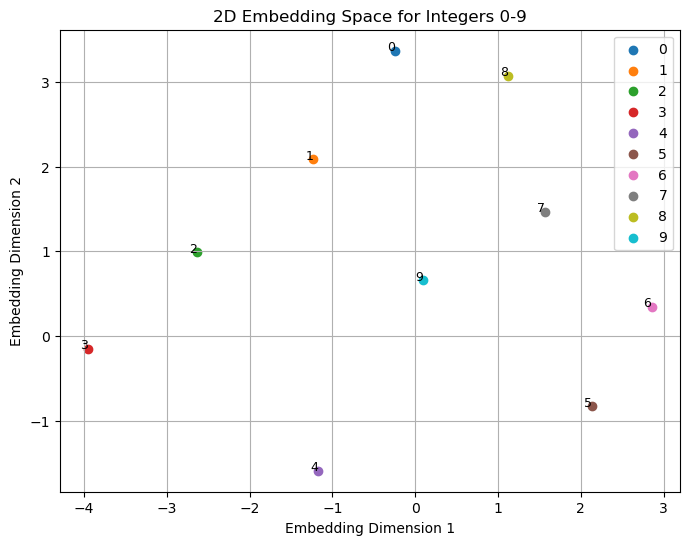

In [54]:
plot_embeddings(embedding)

**Que: Train this new network. Are you successful? On a 2D axis, plot the embedding for the first problem, and the embedding for the second problem. Do you notice anything about where the different integers are embedded, between the two problems?**

Note: Already plotted above at the end of each part

#Problem 4:

In [75]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [76]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10).to(device)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
# Training Loop
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f'Training loss: {avg_loss}')
    return avg_loss

# Test Loop
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(test_loader)
    print(f'Test loss: {avg_loss}, Accuracy: {100 * correct / total}%')
    return avg_loss, correct / total

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

Epoch 1/100
Training loss: 1.9560319593800304
Test loss: 1.6443525230884553, Accuracy: 40.21%
Epoch 2/100
Training loss: 1.6371190968681784
Test loss: 1.4648887491226197, Accuracy: 46.17%
Epoch 3/100
Training loss: 1.6135975073670488
Test loss: 1.4839305508136749, Accuracy: 47.93%
Epoch 4/100
Training loss: 1.5921035126956833
Test loss: 2.0011100471019745, Accuracy: 42.48%
Epoch 5/100
Training loss: 1.542253418346805
Test loss: 1.4366013062000276, Accuracy: 49.74%
Epoch 6/100
Training loss: 1.4911930231791932
Test loss: 1.5220445680618286, Accuracy: 46.04%
Epoch 7/100
Training loss: 1.352629101794699
Test loss: 1.412845916748047, Accuracy: 55.02%
Epoch 8/100
Training loss: 1.2483789951295194
Test loss: 1.4029102575778962, Accuracy: 51.92%
Epoch 9/100
Training loss: 1.1921191371005515
Test loss: 1.1257265216112138, Accuracy: 61.0%
Epoch 10/100
Training loss: 1.3393641614243197
Test loss: 1.2736638599634171, Accuracy: 54.84%
Epoch 11/100
Training loss: 1.4503518089918834
Test loss: 4.045

#Problem 5:

In [2]:
class EmbeddingNetwork(nn.Module):
    def __init__(self):
        super(EmbeddingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*8*8, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 50)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [3]:
def similarity_function(x, y):
    return (x == y).float()

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [5]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model initialization
model = EmbeddingNetwork()
criterion = ContrastiveLoss(margin=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def plot_embeddings():
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data in test_loader:
            images, targets = data
            outputs = model(images)
            embeddings.extend(outputs.numpy())  # Store the embeddings
            labels.extend(targets.numpy())  # Store the labels

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.title('2D Embeddings of CIFAR-10 Test Images')
    plt.show()

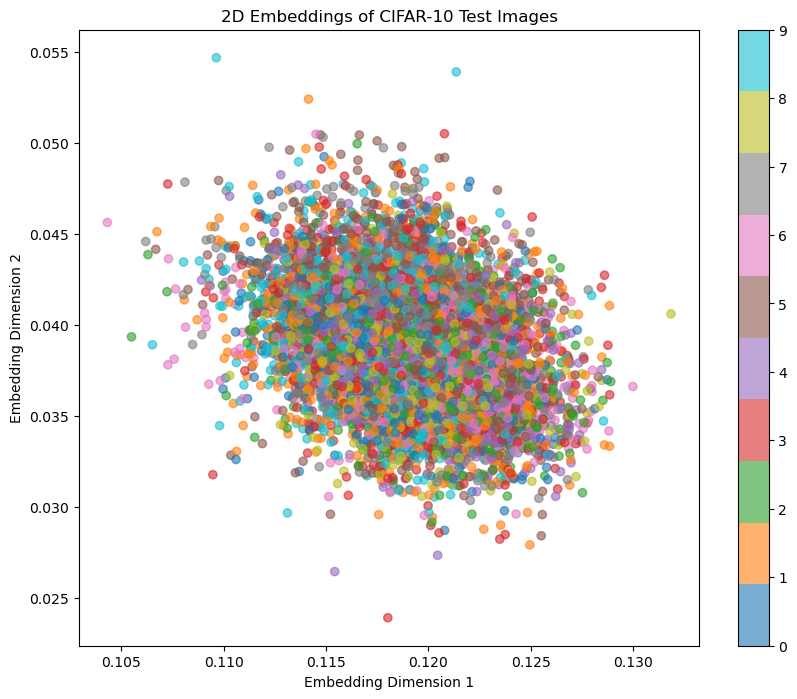

In [7]:
plot_embeddings()

In [8]:
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        img, label = data
        idx = torch.randperm(img.size(0))
        img_shuffled = img[idx]
        label_shuffled = label[idx]

        optimizer.zero_grad()
        output1 = model(img)
        output2 = model(img_shuffled)
        loss = criterion(output1, output2, similarity_function(label, label_shuffled))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    return avg_train_loss

def test():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            idx = torch.randperm(img.size(0))
            img_shuffled = img[idx]
            label_shuffled = label[idx]

            output1 = model(img)
            output2 = model(img_shuffled)
            loss = criterion(output1, output2, similarity_function(label, label_shuffled))
            total_loss += loss.item()

    avg_test_loss = total_loss / len(test_loader)
    return avg_test_loss

# Main Loop with Reporting Modifications
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(epoch)
    test_loss = test()
    print(f'Epoch {epoch + 1}: Avg Train Loss: {train_loss:.4f}, Avg Test Loss: {test_loss:.4f}')

Epoch 1: Avg Train Loss: 0.7060, Avg Test Loss: 0.6263
Epoch 2: Avg Train Loss: 0.6301, Avg Test Loss: 0.6094
Epoch 3: Avg Train Loss: 0.6171, Avg Test Loss: 0.6088
Epoch 4: Avg Train Loss: 0.5982, Avg Test Loss: 0.6534
Epoch 5: Avg Train Loss: 0.5934, Avg Test Loss: 0.6283
Epoch 6: Avg Train Loss: 0.5821, Avg Test Loss: 0.5541
Epoch 7: Avg Train Loss: 0.5713, Avg Test Loss: 0.5913
Epoch 8: Avg Train Loss: 0.5704, Avg Test Loss: 0.5420
Epoch 9: Avg Train Loss: 0.5775, Avg Test Loss: 0.5994
Epoch 10: Avg Train Loss: 0.5689, Avg Test Loss: 0.5626


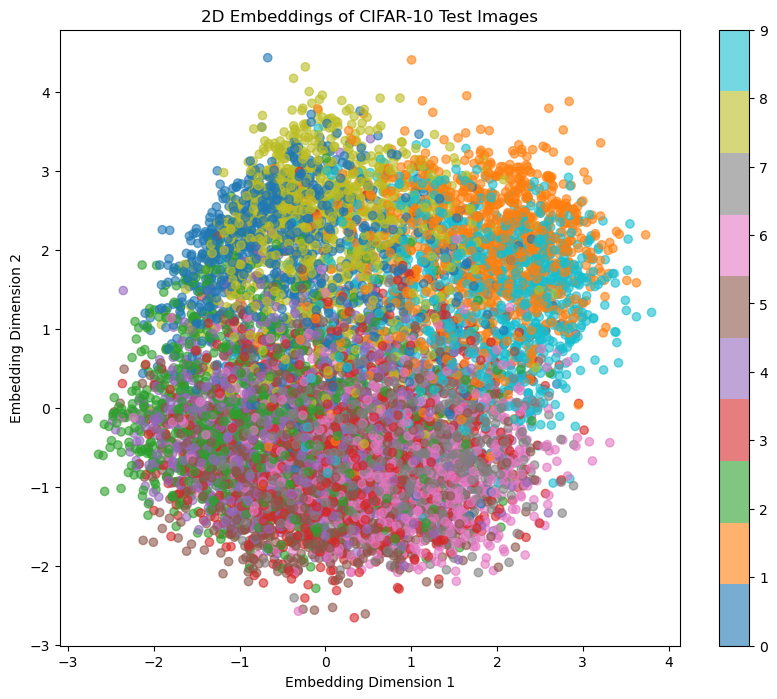

In [9]:
plot_embeddings()